In [1]:
from pprint import pprint
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
#from cnn_utils import *
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import deepdish.io as io
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Dropout, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import multi_gpu_model
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc
import random

Using TensorFlow backend.


In [2]:
data_train = io.load(os.path.join('DarkMachineTrain.h5'))
data_test = io.load(os.path.join('DarkMachineTest.h5'))

IOError: ``DarkMachineTrain.h5`` does not exist

In [3]:
X_train = data_train['X']

y_train = data_train['y']

X_test = data_test['X']

y_test = data_test['y']


In [4]:
#Defining Sequential Model

#def sequential_model():
   # seqModel = Sequential()
   # seqModel.add(Dense(32, input_dim=30, kernel_initializer='glorot_normal', activation='relu'))
   # seqModel.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
   # seqModel.add(Dense(1, kernel_initializer='glorot_normal',activation='sigmoid'))
   # seqModel.compile(loss='mean_squared_error', optimizer='adam')
   # return seqModel

def sequential_model():
    seqModel = Sequential()
    seqModel.add(Dense(128, input_dim=113, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(32, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(16, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(1, kernel_initializer='glorot_normal',activation='sigmoid'))
    seqModel.compile(loss='binary_crossentropy', optimizer='adam')
    return seqModel

In [5]:
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_train)
X_test1 = sc_X.fit_transform(X_test)
sig_model = sequential_model()
sig_train = sig_model.fit(X_train1, y_train, epochs=50, batch_size=256, verbose=1)

Epoch 1/50
2420718/2420718 [==============================] - 25s 10us/step - loss: 0.0311
Epoch 2/50
2420718/2420718 [==============================] - 28s 12us/step - loss: 0.0262
Epoch 3/50
2420718/2420718 [==============================] - 31s 13us/step - loss: 0.0254
Epoch 4/50
2420718/2420718 [==============================] - 29s 12us/step - loss: 0.0250
Epoch 5/50
2420718/2420718 [==============================] - 28s 12us/step - loss: 0.0247
Epoch 6/50
2420718/2420718 [==============================] - 29s 12us/step - loss: 0.0244
Epoch 7/50
2420718/2420718 [==============================] - 28s 12us/step - loss: 0.0242
Epoch 8/50
2420718/2420718 [==============================] - 28s 12us/step - loss: 0.0240
Epoch 9/50
2420718/2420718 [==============================] - 30s 12us/step - loss: 0.0237
Epoch 10/50
2420718/2420718 [==============================] - 29s 12us/step - loss: 0.0235
Epoch 11/50
2420718/2420718 [==============================] - 29s 12us/step - loss: 0.02

In [6]:
sig_predict = sig_model.predict(X_test1,batch_size=256, verbose=1)

806907/806907 [==============================] - 3s 4us/step


/home/debo/env5/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


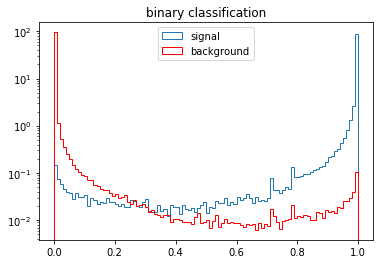

In [7]:
sigSoft= sig_predict[np.where(y_test==1)]
bkgSoft = sig_predict[np.where(y_test==0)]
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('binary classification')

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


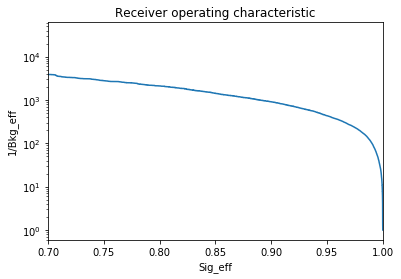

In [8]:
fpr, tpr, thresholds = roc_curve(y_test,sig_predict)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr, 1/fpr)
plt.xlim([0.70, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')
plt.show()

In [13]:
from numba import cuda

ImportError: No module named numba

In [9]:
d = io.load('MEM-A-dbsigwoSpectator.h5')
#ix = [random.sample(range(4), 4) for _ in xrange(d['X'].shape[0])]
ix = np.argsort(d['X'][:, :4])[:, ::-1]

def _pairwise(iterable):
        '''s -> (s0, s1), (s2, s3), (s4, s5), ...'''
        a = iter(iterable)
        return izip(a, a)

cols = [(0, 4), (8, 12), (15, 19), (23, 27)]
for slc in cols:
      print 'Shuffling columns {}'.format(slc)
      d['X'][:, slice(*slc)] = np.array([row[sh] for row, sh in zip(d['X'][:, slice(*slc)], ix)])

X_ordered = d['X']

Shuffling columns (0, 4)
Shuffling columns (8, 12)
Shuffling columns (15, 19)
Shuffling columns (23, 27)


In [10]:
d1 = io.load('MEM-A-dbsigwoSpectator.h5')
ix = [random.sample(range(4), 4) for _ in xrange(d['X'].shape[0])]
#ix = np.argsort(d['X'][:, :4])[:, ::-1]

def _pairwise(iterable):
        '''s -> (s0, s1), (s2, s3), (s4, s5), ...'''
        a = iter(iterable)
        return izip(a, a)

cols = [(0, 4), (8, 12), (15, 19), (23, 27)]
for slc in cols:
      print 'Shuffling columns {}'.format(slc)
      d1['X'][:, slice(*slc)] = np.array([row[sh] for row, sh in zip(d1['X'][:, slice(*slc)], ix)])

X_shuffled = d1['X']

Shuffling columns (0, 4)
Shuffling columns (8, 12)
Shuffling columns (15, 19)
Shuffling columns (23, 27)


In [11]:
X_Big_train[0,:]

array([ 27.841465  ,  44.4723587 , 158.54547119,  84.47756195,
        33.08669281,  45.23552322,  30.96371078,  99.27610016,
        -2.47801948,  -0.59272784,   0.81551963,   1.16164672,
         1.35580003,   0.29000273,   0.51065123,  -1.00646257,
        -2.96687794,  -1.44353414,   1.4412297 ,  -1.07279122,
         2.97015858,   1.87047517,   0.23963417, 167.13642364,
        52.72582413, 214.3066673 , 148.25495962,  68.44982856,
        47.15108169,  35.08932617])

In [12]:
X_ordered[0,:]

array([158.54547119,  84.47756195,  44.4723587 ,  27.841465  ,
        33.08669281,  45.23552322,  30.96371078,  99.27610016,
         0.81551963,   1.16164672,  -0.59272784,  -2.47801948,
         1.35580003,   0.29000273,   0.51065123,  -1.44353414,
         1.4412297 ,  -2.96687794,  -1.00646257,  -1.07279122,
         2.97015858,   1.87047517,   0.23963417, 214.3066673 ,
       148.25495962,  52.72582413, 167.13642364,  68.44982856,
        47.15108169,  35.08932617])

In [13]:
X_shuffled[0,:]

array([ 27.841465  ,  84.47756195, 158.54547119,  44.4723587 ,
        33.08669281,  45.23552322,  30.96371078,  99.27610016,
        -2.47801948,   1.16164672,   0.81551963,  -0.59272784,
         1.35580003,   0.29000273,   0.51065123,  -1.00646257,
         1.4412297 ,  -1.44353414,  -2.96687794,  -1.07279122,
         2.97015858,   1.87047517,   0.23963417, 167.13642364,
       148.25495962, 214.3066673 ,  52.72582413,  68.44982856,
        47.15108169,  35.08932617])

In [14]:
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_ordered)
X_test1 = sc_X.fit_transform(X_Big_test)
sig_model = sequential_model()
sig_train = sig_model.fit(X_train1, y_BigSig_train, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
1548745/1548745 [==============================] - 19s 12us/step - loss: 0.1286
Epoch 2/20
1548745/1548745 [==============================] - 19s 12us/step - loss: 0.0761
Epoch 3/20
1548745/1548745 [==============================] - 19s 12us/step - loss: 0.0652
Epoch 4/20
1548745/1548745 [==============================] - 18s 12us/step - loss: 0.0598
Epoch 5/20
1548745/1548745 [==============================] - 19s 12us/step - loss: 0.0565
Epoch 6/20
1548745/1548745 [==============================] - 19s 12us/step - loss: 0.0539
Epoch 7/20
1548745/1548745 [==============================] - 20s 13us/step - loss: 0.0521
Epoch 8/20
1548745/1548745 [==============================] - 20s 13us/step - loss: 0.0505
Epoch 9/20
1548745/1548745 [==============================] - 20s 13us/step - loss: 0.0493
Epoch 10/20
1548745/1548745 [==============================] - 19s 12us/step - loss: 0.0483
Epoch 11/20
1548745/1548745 [==============================] - 20s 13us/step - loss: 0.04

In [15]:
sig_predict_ordered = sig_model.predict(X_test1,batch_size=256, verbose=1)

516249/516249 [==============================] - 2s 4us/step


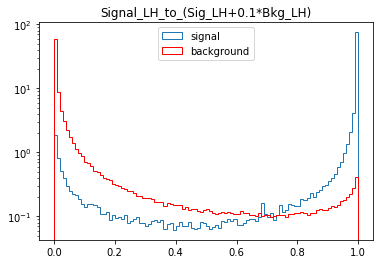

In [16]:
sigSoft= sig_predict_ordered[np.where(y_BigSig_test==1)]
bkgSoft = sig_predict_ordered[np.where(y_BigSig_test==0)]
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


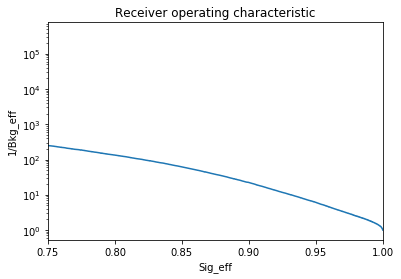

In [17]:
fpr_ordered, tpr_ordered, thresholds_ordered = roc_curve(y_BigSig_test,sig_predict_ordered)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr_ordered, 1/fpr_ordered)
plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')
plt.show()

In [18]:
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_shuffled)
X_test1 = sc_X.fit_transform(X_Big_test)
sig_model = sequential_model()
sig_train = sig_model.fit(X_train1, y_BigSig_train, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
1548745/1548745 [==============================] - 19s 12us/step - loss: 0.1402
Epoch 2/20
1548745/1548745 [==============================] - 18s 11us/step - loss: 0.0886
Epoch 3/20
1548745/1548745 [==============================] - 17s 11us/step - loss: 0.0781
Epoch 4/20
1548745/1548745 [==============================] - 18s 12us/step - loss: 0.0727
Epoch 5/20
1548745/1548745 [==============================] - 17s 11us/step - loss: 0.0699
Epoch 6/20
1548745/1548745 [==============================] - 18s 11us/step - loss: 0.0678
Epoch 7/20
1548745/1548745 [==============================] - 18s 11us/step - loss: 0.0661
Epoch 8/20
1548745/1548745 [==============================] - 17s 11us/step - loss: 0.0648
Epoch 9/20
1548745/1548745 [==============================] - 17s 11us/step - loss: 0.0636
Epoch 10/20
1548745/1548745 [==============================] - 17s 11us/step - loss: 0.0626
Epoch 11/20
1548745/1548745 [==============================] - 17s 11us/step - loss: 0.06

In [19]:
sig_predict_shuffled = sig_model.predict(X_test1,batch_size=256, verbose=1)

516249/516249 [==============================] - 2s 4us/step


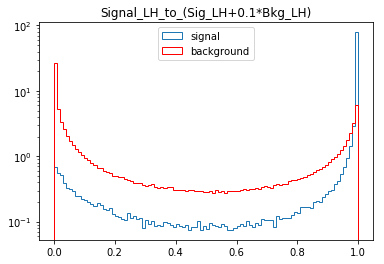

In [20]:
sigSoft= sig_predict_shuffled[np.where(y_BigSig_test==1)]
bkgSoft = sig_predict_shuffled[np.where(y_BigSig_test==0)]
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


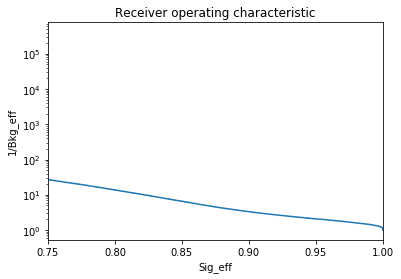

In [21]:
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(y_BigSig_test,sig_predict_shuffled)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr_shuffled, 1/fpr_shuffled)
plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')

plt.show()

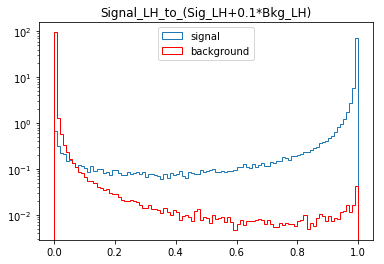

In [22]:
sigSoft= softTarget_test[np.where(y_BigSig_test==1)]
bkgSoft = softTarget_test[np.where(y_BigSig_test==0)]
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


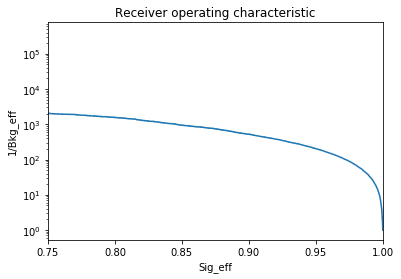

In [23]:
fpr_MEM, tpr_MEM, thresholds_MEM = roc_curve(y_BigSig_test,softTarget_test)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr_MEM, 1/fpr_MEM)
plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')

plt.show()

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


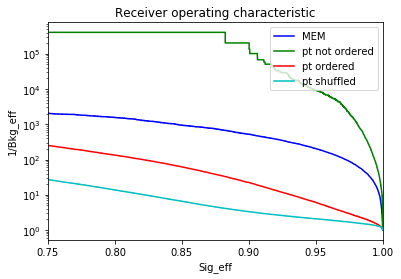

In [24]:
plt.figure()
plt.plot(tpr_MEM, 1/fpr_MEM, label='MEM',color='b')
plt.plot(tpr, 1/fpr, label='pt not ordered',color='g')
plt.plot(tpr_ordered, 1/fpr_ordered, label='pt ordered',color='r')
plt.plot(tpr_shuffled, 1/fpr_shuffled, label='pt shuffled',color='c')

plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

In [12]:
back_model = sequential_model()
back_train = back_model.fit(X_train1, target_BigBack_train, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 119.8905
Epoch 2/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 36.0977
Epoch 3/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 36.0313
Epoch 4/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 36.0082
Epoch 5/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 35.9936
Epoch 6/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 35.9904
Epoch 7/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 35.9826
Epoch 8/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 35.9787
Epoch 9/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 35.9736
Epoch 10/20
3028985/3028985 [==============================] - 18s 6us/step - loss: 35.9719
Epoch 11/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 35.9

In [13]:
#evaluating signal model
sig_test = sig_model.evaluate(X_test1, target_BigSig_test, batch_size=256, verbose=1)

151449/151449 [==============================] - 1s 3us/step


In [14]:
back_test = back_model.evaluate(X_test1, target_BigBack_test, batch_size=256, verbose=1)

151449/151449 [==============================] - 0s 3us/step


In [15]:
sig_predict = sig_model.predict(X_test1,verbose=1)

151449/151449 [==============================] - 2s 14us/step


In [16]:
back_predict = back_model.predict(X_test1,verbose=1)

151449/151449 [==============================] - 2s 14us/step


In [17]:
# summarize history for loss
signal_history = sig_model.fit(X_train1, target_BigSig_train, epochs=20, batch_size=256, validation_split=0.3, verbose=1)


Train on 2120289 samples, validate on 908696 samples
Epoch 1/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.9869 - val_loss: 24.9070
Epoch 2/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.9541 - val_loss: 24.7771
Epoch 3/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.9212 - val_loss: 24.7099
Epoch 4/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 24.9095 - val_loss: 24.7589
Epoch 5/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.8891 - val_loss: 24.9165
Epoch 6/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.8712 - val_loss: 25.3133
Epoch 7/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.8539 - val_loss: 24.7523
Epoch 8/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.8444 - val_loss: 24.8005
Epoch 9/20
2120289/2120289 [==============================]

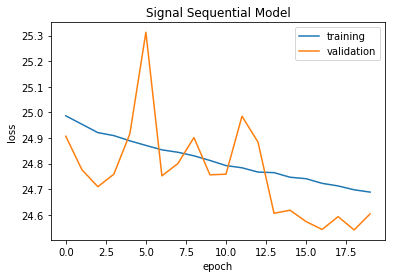

In [24]:
signal_history.history.keys()
plt.plot(signal_history.history['loss'])
plt.plot(signal_history.history['val_loss'])
plt.title('Signal Sequential Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [31]:
# summarize history for loss
background_history = back_model.fit(X_train1, target_BigBack_train, epochs=20, batch_size=256, validation_split=0.3, verbose=1)


Train on 2120289 samples, validate on 908696 samples
Epoch 1/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 35.9019 - val_loss: 36.0100
Epoch 2/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 35.9066 - val_loss: 35.9335
Epoch 3/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 35.9008 - val_loss: 35.9559
Epoch 4/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 35.9013 - val_loss: 35.9956
Epoch 5/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 35.9042 - val_loss: 35.9140
Epoch 6/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 35.8972 - val_loss: 36.0473
Epoch 7/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 35.8940 - val_loss: 35.9622
Epoch 8/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 35.8887 - val_loss: 35.9310
Epoch 9/20
2120289/2120289 [==============================]

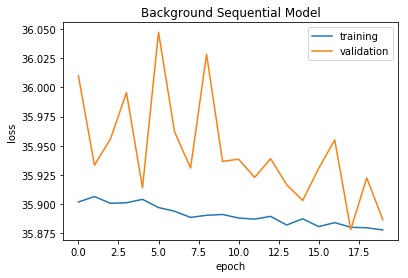

In [32]:
background_history.history.keys()
plt.plot(background_history.history['loss'])
plt.plot(background_history.history['val_loss'])
plt.title('Background Sequential Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [29]:
sti=sig_true_i=np.where(y_BigSig_test==1)[0]
bti=bkg_true_i=np.where(y_BigBack_test==0)[0]
print np.shape(sig_predict[sti])
print np.shape(target_BigSig_test[sti])
print np.shape(back_predict[bti])
print np.shape(target_BigBack_test[bti])

(90674, 1)
(90674,)
(60903, 1)
(60903,)


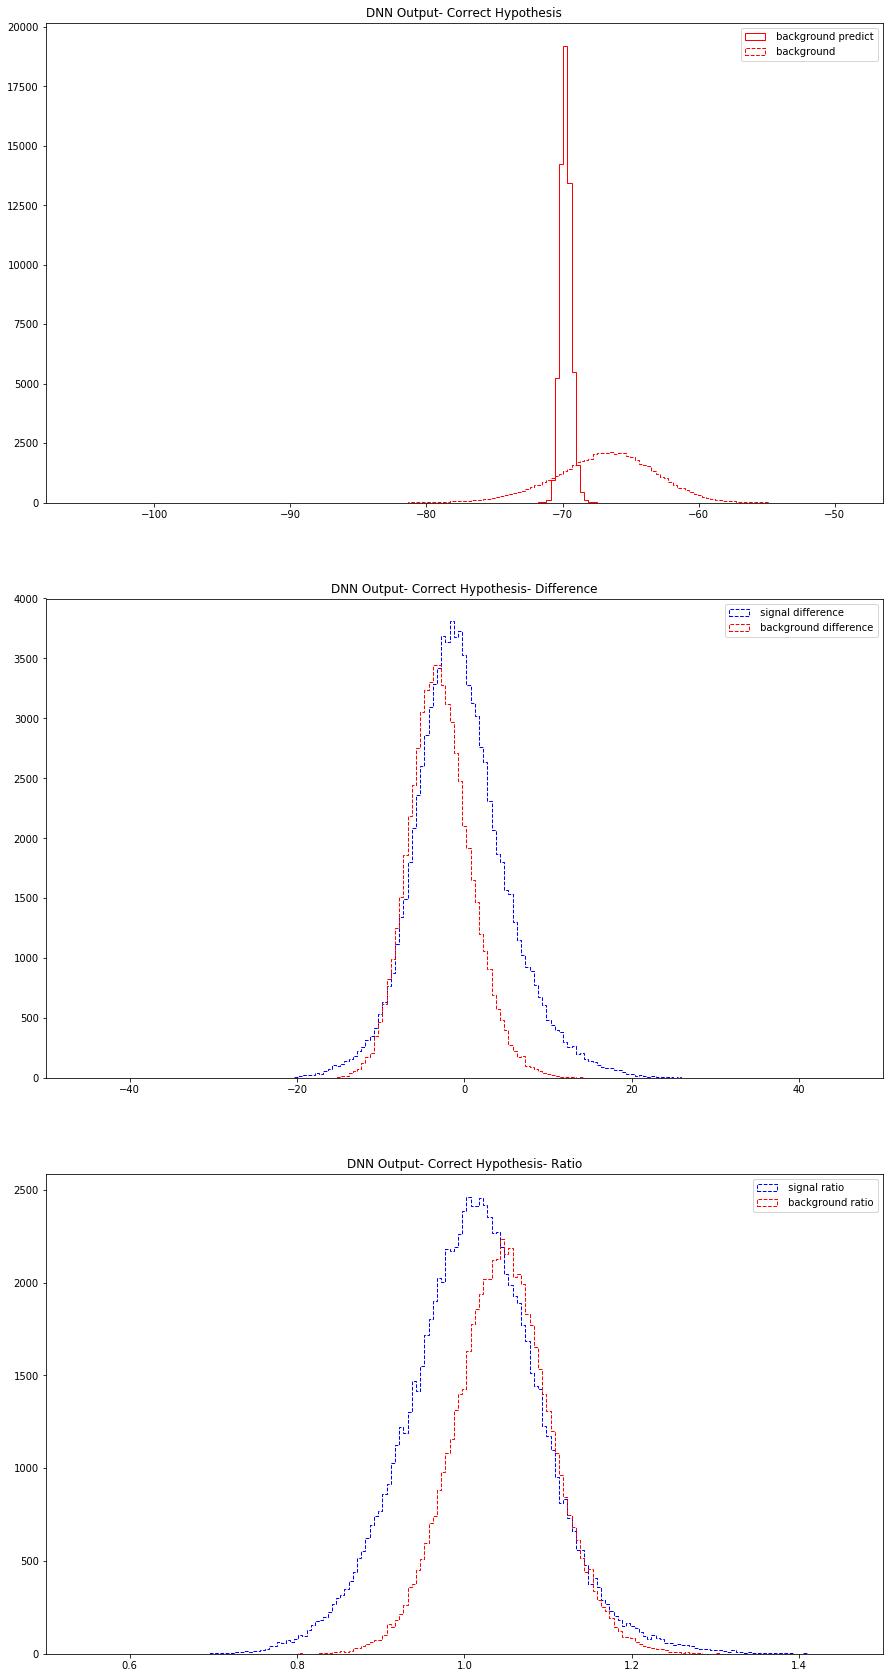

In [30]:
n_datasets = 1
n_plots = 3
n_bins = 200
f, axarr = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(15, 30),
                            squeeze=False)
plot_i=0
plot_title="DNN Output- Correct Hypothesis"

min_out=min(target_BigSig_test.min(),sig_predict.min())
max_out=max(target_BigSig_test.max(),sig_predict.max())
bins_out = np.linspace(min_out,max_out,n_bins)
axarr[plot_i,0].set_xlim((min_out,max_out))
        
#axarr[plot_i,0].hist(sig_predict[sti], color='blue', histtype='step', bins=bins_out, linestyle='solid', label=' signal predict')
#axarr[plot_i,0].hist(target_BigSig_test[sti], color='blue', histtype='step', bins=bins_out, linestyle='dashed', label=' signal')

axarr[plot_i,0].hist(back_predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
axarr[plot_i,0].hist(target_BigBack_test[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background') 
#axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

# Plot the Difference 
i=1
plot_i=0
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Difference"

target_BigSig = target_BigSig_test[sti]
target_BigSig = target_BigSig.reshape(90674,1)
target_BigBack = target_BigBack_test[bti]
target_BigBack = target_BigBack.reshape(60903,1)

diff_sig=sig_predict[sti]-target_BigSig
diff_bkg=back_predict[bti]-target_BigBack
#print diff_sig
#print diff_bkg

min_diff=-50
max_diff=50
bins_diff = np.linspace(min_diff,max_diff,n_bins)

axarr[plot_i,0].set_xlim((min_diff,max_diff))
        
axarr[plot_i,0].hist(diff_sig, color='blue', histtype='step', bins=bins_diff, linestyle='dashed', label=' signal difference')
axarr[plot_i,0].hist(diff_bkg, color='red', histtype='step',bins=bins_diff, linestyle='dashed', label=' background difference')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

# Plot the Ratio
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Ratio"

ratio_sig=sig_predict[sti]/target_BigSig
ratio_bkg=back_predict[bti]/target_BigBack

min_ratio=0.5
max_ratio=1.5

bins_ratio = np.linspace(min_ratio,max_ratio,n_bins)

axarr[plot_i,0].set_xlim((min_ratio,max_ratio))
        
axarr[plot_i,0].hist(ratio_sig, color='blue', histtype='step', bins=bins_ratio, linestyle='dashed', label=' signal ratio')
axarr[plot_i,0].hist(ratio_bkg, color='red', histtype='step',bins=bins_ratio, linestyle='dashed', label=' background ratio')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

In [25]:
##Defining Res_Net model
#def resnet_model(input_dim, output_dim, target):
def resnet_model(input_dim, output_dim):
    def _build_residual_block(x, apply_first=lambda x: x, apply_last=lambda x: x):
        indim = 40
        skip = apply_first(x)
        h = Dense(60)(x)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = Dense(50)(x)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = Dense(indim)(h)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = apply_last(h)
        h = Dense(indim)(h)
        #Add()([X, X_shortcut])

        return LeakyReLU()(Add()([h, skip]))
    x = Input(shape=(input_dim, ))

    h = Dense(40)(x)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = _build_residual_block(h)

    h = Dense(40)(x)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = _build_residual_block(h)
    #h = _build_residual_block(h, apply_last=_build_residual_block)

    h = Dense(output_dim)(h)
    #y = Activation('sigmoid')(h)
    #if target == 'llhs':
    y = h
    #else:
    #y = Activation('sigmoid')(h) # soft and hard target are constrained between 0 and 1

    return Model(x, y)

In [26]:
model = resnet_model(input_dim =32, output_dim=1)
model.compile(loss='mean_squared_error', optimizer='adam')
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_Big_train)
X_test1 = sc_X.fit_transform(X_Big_test)
signal_ResNet_history = sig_model.fit(X_train1, target_BigSig_train, epochs=20, batch_size=256, validation_split=0.3, verbose=1)
#resTrain = model.fit(X_train1,target_BigSig_train, epochs=20, batch_size=256, verbose=1)
#res_Result = model.predict(X_test1)
#print np.shape(res_Result), np.max(res_Result), np.min(res_Result)

Train on 2120289 samples, validate on 908696 samples
Epoch 1/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.6718 - val_loss: 24.6021
Epoch 2/20
2120289/2120289 [==============================] - 14s 7us/step - loss: 24.6501 - val_loss: 24.4204
Epoch 3/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 24.6375 - val_loss: 24.3943
Epoch 4/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 24.6287 - val_loss: 24.5106
Epoch 5/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 24.6168 - val_loss: 24.4463
Epoch 6/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 24.6097 - val_loss: 24.4155
Epoch 7/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 24.5953 - val_loss: 24.5026
Epoch 8/20
2120289/2120289 [==============================] - 15s 7us/step - loss: 24.5985 - val_loss: 24.5532
Epoch 9/20
2120289/2120289 [==============================]

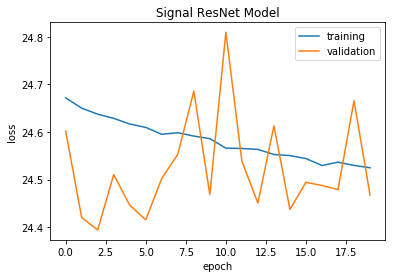

In [27]:
signal_ResNet_history.history.keys()
plt.plot(signal_ResNet_history.history['loss'])
plt.plot(signal_ResNet_history.history['val_loss'])
plt.title('Signal ResNet Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [33]:
model = resnet_model(input_dim =32, output_dim=1)
model.compile(loss='mean_squared_error', optimizer='adam')
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_Big_train)
X_test1 = sc_X.fit_transform(X_Big_test)
res_Back_Train = model.fit(X_train1,target_BigBack_train, epochs=20, batch_size=256, verbose=1)
res_Back_Predict = model.predict(X_test1)
print np.shape(res_Result), np.max(res_Result), np.min(res_Result)

Epoch 1/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 96.5806
Epoch 2/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.9252
Epoch 3/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.8827
Epoch 4/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.8575
Epoch 5/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.8484
Epoch 6/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.8428
Epoch 7/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.8379
Epoch 8/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.8373
Epoch 9/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.8376
Epoch 10/20
3028985/3028985 [==============================] - 37s 12us/step - loss: 35.8365
Epoch 11/20
3028985/3028985 [==============================] - 37s 12us/step - 

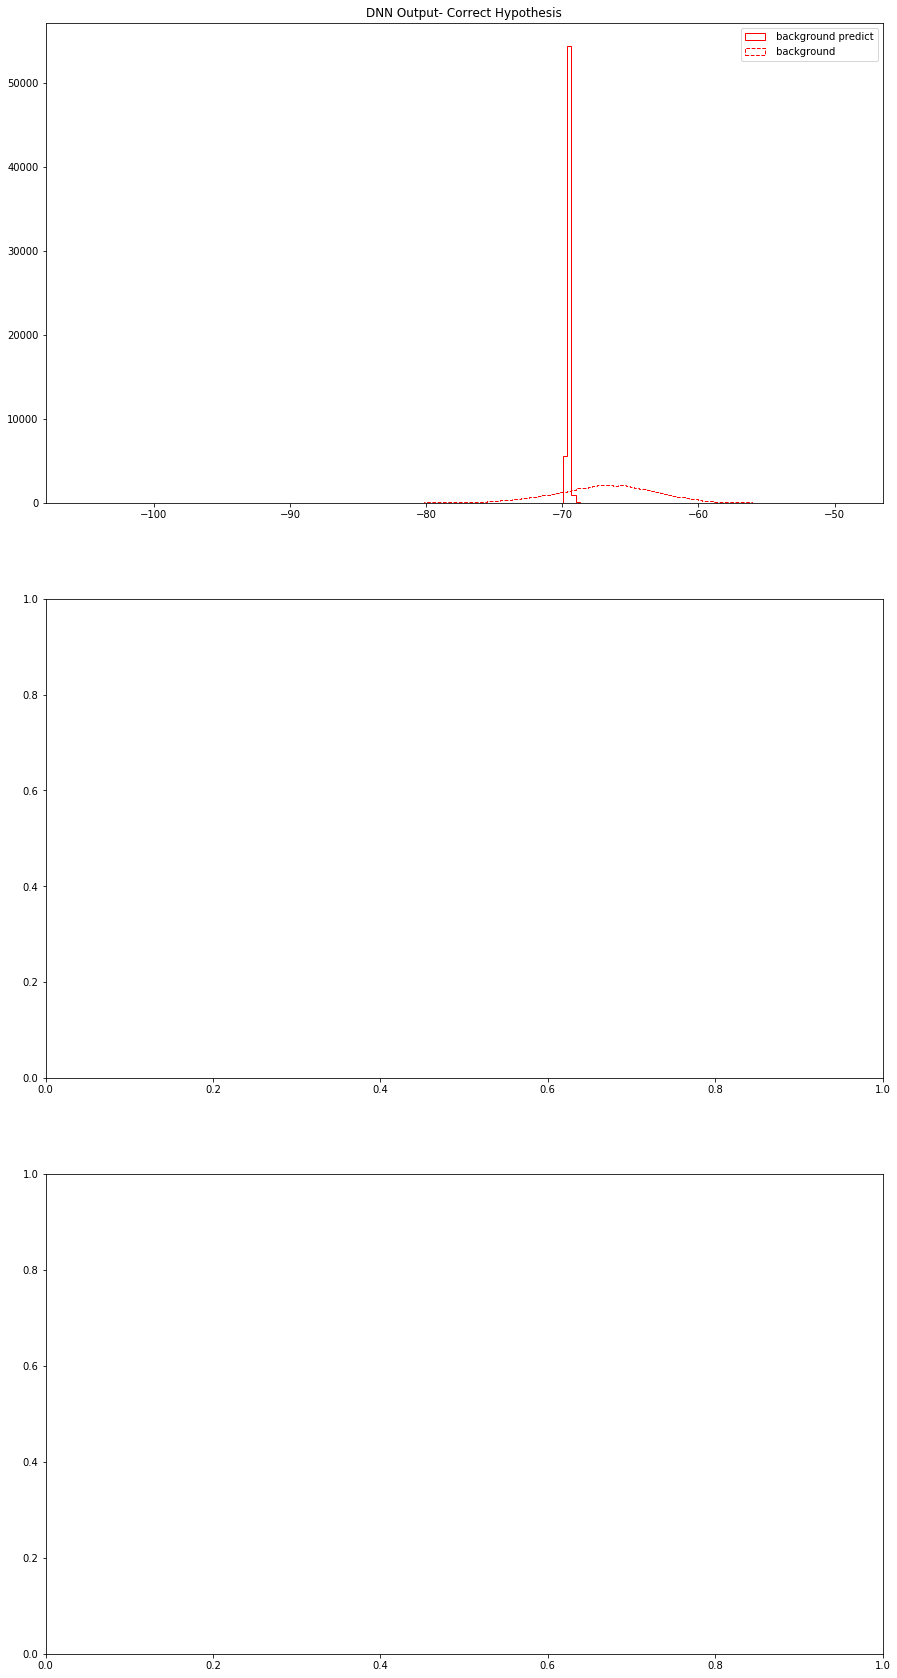

In [35]:
n_datasets = 1
n_plots = 3
n_bins = 200
f, axarr = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(15, 30),
                            squeeze=False)
plot_i=0
plot_title="DNN Output- Correct Hypothesis"

min_out=min(target_BigSig_test.min(),sig_predict.min())
max_out=max(target_BigSig_test.max(),sig_predict.max())
bins_out = np.linspace(min_out,max_out,n_bins)
axarr[plot_i,0].set_xlim((min_out,max_out))
        
#axarr[plot_i,0].hist(sig_predict[sti], color='blue', histtype='step', bins=bins_out, linestyle='solid', label=' signal predict')
#axarr[plot_i,0].hist(target_BigSig_test[sti], color='blue', histtype='step', bins=bins_out, linestyle='dashed', label=' signal')

axarr[plot_i,0].hist(res_Back_Predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
axarr[plot_i,0].hist(target_BigBack_test[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background') 
#axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)


In [36]:
# summarize history for loss
ResNet_background_history = model.fit(X_train1, target_BigBack_train, epochs=20, batch_size=256, validation_split=0.3, verbose=1)

Train on 2120289 samples, validate on 908696 samples
Epoch 1/20
2120289/2120289 [==============================] - 30s 14us/step - loss: 35.8104 - val_loss: 35.8351
Epoch 2/20
2120289/2120289 [==============================] - 30s 14us/step - loss: 35.8115 - val_loss: 35.8376
Epoch 3/20
2120289/2120289 [==============================] - 29s 14us/step - loss: 35.8096 - val_loss: 35.8649
Epoch 4/20
2120289/2120289 [==============================] - 29s 14us/step - loss: 35.8105 - val_loss: 35.9128
Epoch 5/20
2120289/2120289 [==============================] - 30s 14us/step - loss: 35.8146 - val_loss: 35.8275
Epoch 6/20
2120289/2120289 [==============================] - 30s 14us/step - loss: 35.8086 - val_loss: 35.8351
Epoch 7/20
2120289/2120289 [==============================] - 29s 14us/step - loss: 35.8110 - val_loss: 35.8210
Epoch 8/20
2120289/2120289 [==============================] - 29s 14us/step - loss: 35.8121 - val_loss: 35.8759
Epoch 9/20
2120289/2120289 [=======================

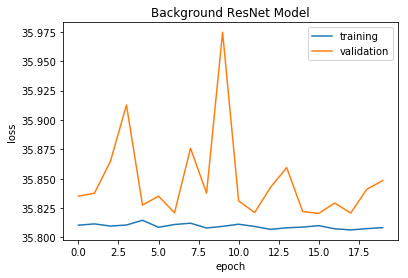

In [37]:
plt.plot(ResNet_background_history.history['loss'])
plt.plot(ResNet_background_history.history['val_loss'])
plt.title('Background ResNet Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()